## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [5]:
import os
import math
import random
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

from preprocess import PersTransformer, DistRemover, Masker
from classes import Line, RoadLane, Tracker, Pipeline
from utils import superimpose_images

## Calibration of the camera and removal of distorsion

### Calibration step

In [6]:
Remover = DistRemover()

Calibrating camera...
Not possible to extract points from image: data/camera_cal/calibration1.jpg.
Not possible to extract points from image: data/camera_cal/calibration5.jpg.
Not possible to extract points from image: data/camera_cal/calibration4.jpg.
Calibration completed...


### Effect of distortion removal

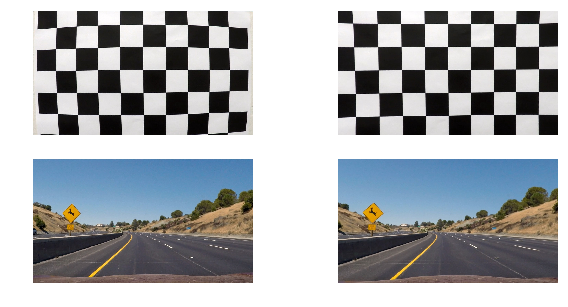

In [7]:
example = 'data/camera_cal/calibration1.jpg'
image = mpimg.imread(example)
example2 = 'data/test_images/test2.jpg'
image2 = mpimg.imread(example2)
plt.figure()
plt.subplot(2,2,1);
plt.axis('off');
plt.imshow(image);
plt.subplot(2,2,2);
plt.axis('off');
undst = Remover.remove_distorsion(image)
plt.imshow(undst);
plt.subplot(2,2,3);
plt.axis('off');
plt.imshow(image2);
plt.subplot(2,2,4);
undst2 = Remover.remove_distorsion(image2)
plt.axis('off')
plt.imshow(undst2);
plt.savefig("data/report_images/undistort.jpg")

## Perspective Transform

In [8]:
Transformer = PersTransformer()

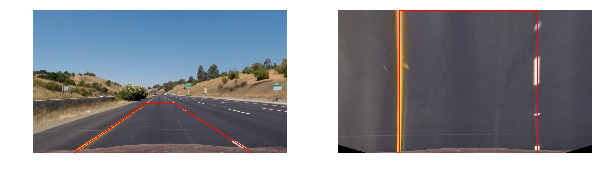

In [10]:
example = 'data/test_images/straight_lines1.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);

warped_img = Transformer.transform(img)
src_points,  dst_points = Transformer.get_points()

for i in range(4):
    imgpoints = cv2.line(img, src_points[i], src_points[(i+1)%4], color=[255,0,0], thickness=4)
    
for i in range(4):
    img_warped_pts = cv2.line(warped_img, dst_points[i], dst_points[(i+1)%4], color=[255,0,0], thickness=3)
    
plt.figure(figsize=(10,3));
plt.subplot(1,2,1);
plt.axis('off');
plt.imshow(imgpoints);
plt.subplot(1,2,2);
plt.axis('off');
plt.imshow(img_warped_pts);
plt.savefig("data/report_images/perspective_straight.jpg")

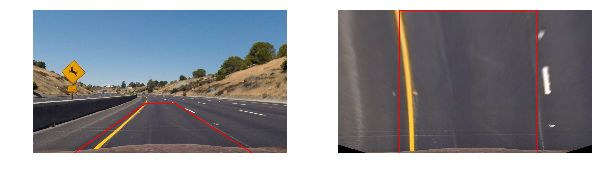

In [11]:
example = 'data/test_images/test2.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);

warped_img = Transformer.transform(img)
src_points,  dst_points = Transformer.get_points()

for i in range(4):
    imgpoints = cv2.line(img, src_points[i], src_points[(i+1)%4], color=[255,0,0], thickness=4)
    
for i in range(4):
    img_warped_pts = cv2.line(warped_img, dst_points[i], dst_points[(i+1)%4], color=[255,0,0], thickness=3)
    
plt.figure(figsize=(10,3));
plt.subplot(1,2,1)
plt.axis('off');
plt.imshow(imgpoints);
plt.subplot(1,2,2);
plt.axis('off');
plt.imshow(img_warped_pts);
plt.savefig("data/report_images/perspective_curved.jpg")

## Thresholded binary image

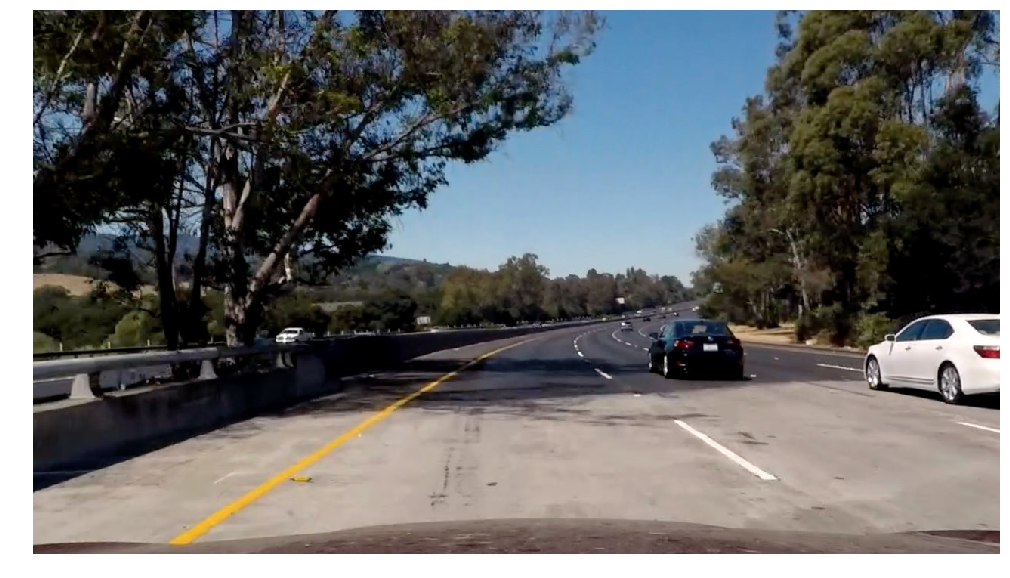

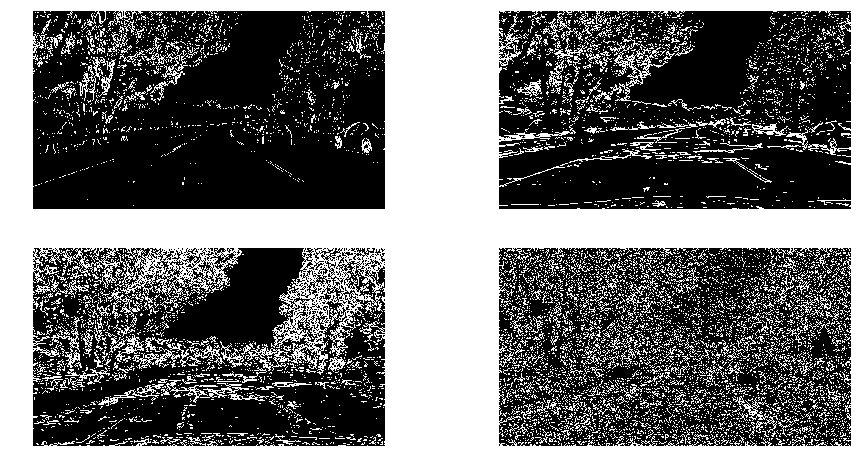

In [15]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);

abs_x = Masker.abs_sobel_mask(img, 0, thresh=(25,255))
abs_y = Masker.abs_sobel_mask(img, 1, thresh=(20,150))
magni = Masker.magnitude_mask(img, 3, thresh=(30,100))
direct = Masker.direction_mask(img, 3, thresh=(0.8,1.3))
plt.figure(figsize=(20,10));
plt.axis('off');
plt.imshow(img);
plt.savefig("data/report_images/original_threshold.jpg");


plt.figure(figsize=(4*5.3,4*3));
plt.figure(figsize=(15.3,8));
plt.subplot(2,2,1);
plt.axis('off');
plt.imshow(abs_x, cmap="gray");
plt.subplot(2,2,2);
plt.axis('off');
plt.imshow(abs_y, cmap="gray");
plt.subplot(2,2,3);
plt.axis('off');
plt.imshow(magni, cmap="gray");
plt.subplot(2,2,4);
plt.axis('off');
plt.imshow(direct, cmap="gray");
plt.savefig("data/report_images/gradient_threshold.jpg");


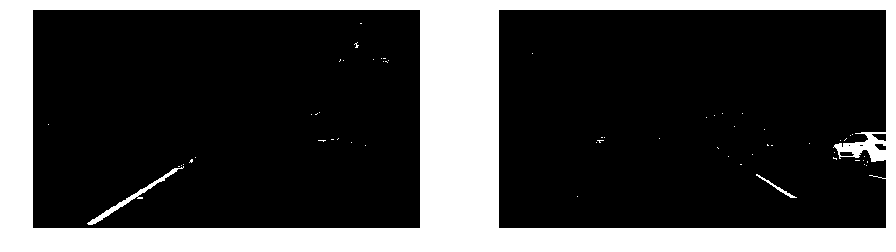

In [25]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);

yellow = Masker.yellow_color_mask(img)
white = Masker.white_color_mask(img)
plt.figure(figsize=(15.3,4));
plt.subplot(1,2,1);
plt.axis('off');
plt.imshow(yellow, cmap="gray");
plt.subplot(1,2,2);
plt.axis('off');
plt.imshow(white, cmap="gray");
plt.savefig("data/report_images/color_threshold.jpg")


#### Comment: Of the gradient masks, the best looks to the abs(x) but it has problems with yellow lines on bright streets. We need therefore to combine it with another kind of mask

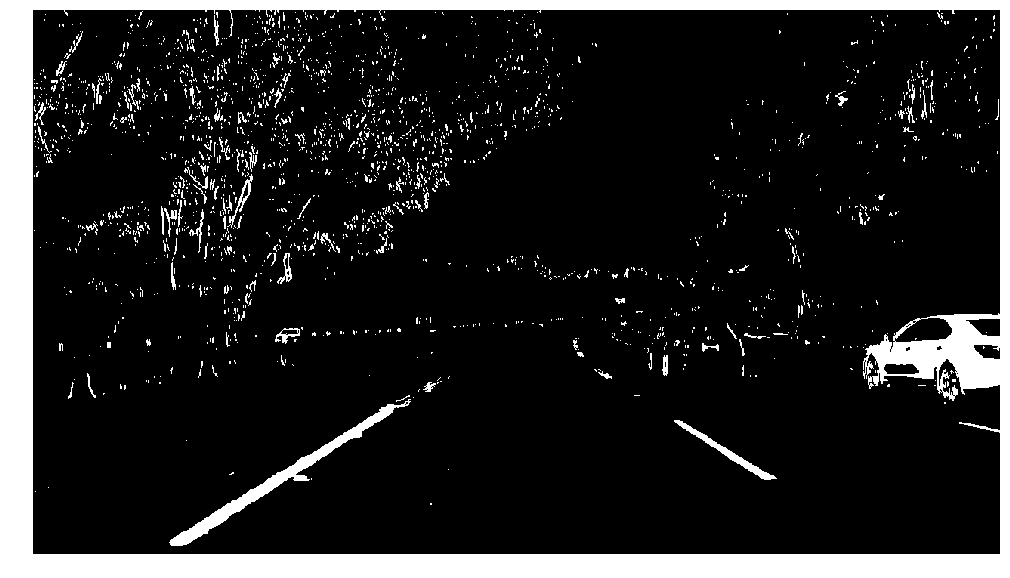

In [28]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);
combined,color,sobel_x = Masker.combined_mask(img)

plt.figure(figsize=(20,10));
plt.axis('off');
plt.imshow(combined, cmap="gray");
plt.savefig("data/report_images/full_threshold.jpg")

## Thresholding and Perspective transform together

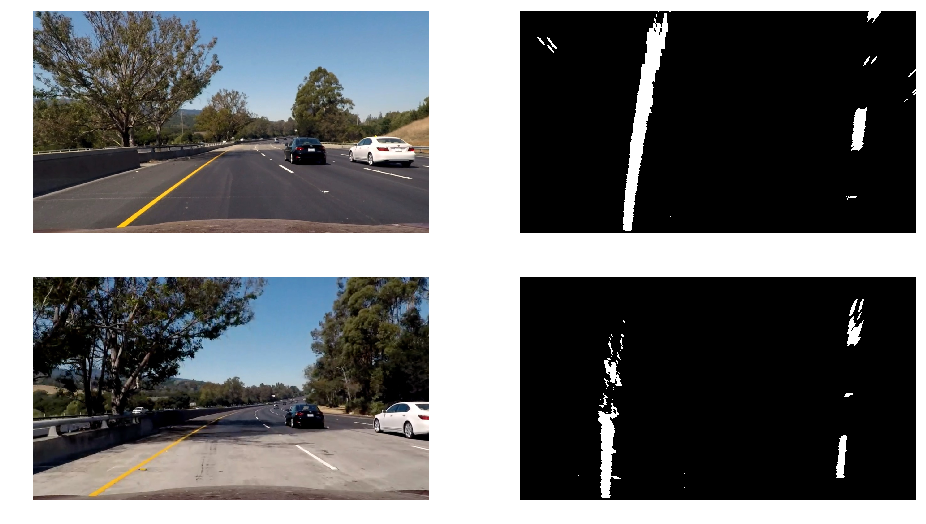

In [30]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);
full_mask, color_mask, sobel_x = Masker.combined_mask(img)
img_warped = Transformer.transform(full_mask)

example2 = 'data/test_images/test6.jpg'
img2 = mpimg.imread(example2) 
img2 = Remover.remove_distorsion(img2);
full_mask2, color_mask2, sobel_x2 = Masker.combined_mask(img2)
img_warped2 = Transformer.transform(full_mask2)


plt.figure(figsize=(16,9));
plt.subplot(2,2,1);
plt.axis('off');
plt.imshow(img2);
plt.subplot(2,2,2);
plt.axis('off');
plt.imshow(img_warped2, cmap="gray");
plt.subplot(2,2,3);
plt.axis('off');
plt.imshow(img);
plt.subplot(2,2,4);
plt.axis('off');
plt.imshow(img_warped, cmap="gray");
plt.savefig("data/report_images/threshold_perspective.jpg")

## Lines identification in single frame

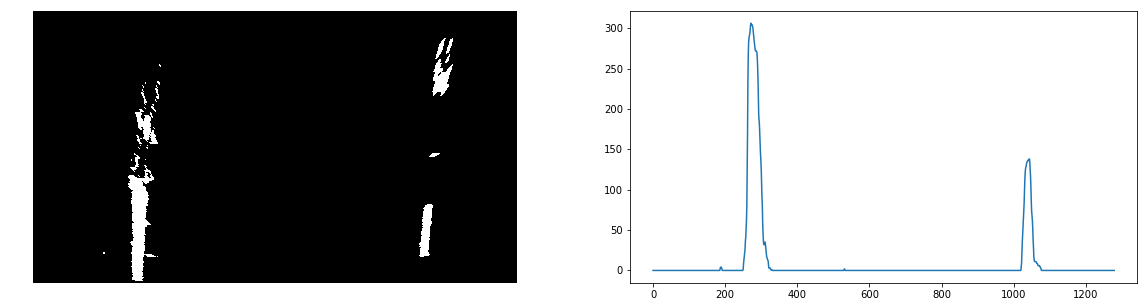

In [39]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);
full_mask, color_mask, sobel_x = Masker.combined_mask(img)
img_warped = Transformer.transform(full_mask)
lane = RoadLane()
_,_, histogram = RoadLane.get_initial_points(img_warped)

plt.figure(figsize=(20,5));
plt.subplot(1,2,2)
plt.plot(histogram)
plt.subplot(1,2,1)
plt.axis('off');
plt.imshow(img_warped, cmap="gray");
plt.savefig("data/report_images/histogram.jpg")

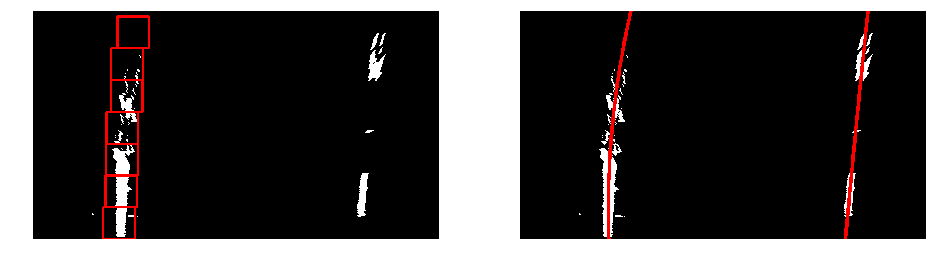

In [41]:
example = 'data/test_images/test5.jpg'
img = mpimg.imread(example) 
img = Remover.remove_distorsion(img);
full_mask, color_mask, sobel_x = Masker.combined_mask(img)
img_warped= Transformer.transform(full_mask)

lane = RoadLane()
init_left, init_right, _ = RoadLane.get_initial_points(img_warped)
_,_,rectangles = lane.rightLine.get_line_pixels(img_warped, init_left)

with_windows = np.stack([255*img_warped,255*img_warped,255*img_warped], axis=2)
for i in range(len(rectangles)):
    cv2.rectangle(with_windows, rectangles[i][0], rectangles[i][1], color=(255,0,0), thickness=6)

lane._generateLane(img_warped) 

prova = np.stack([255*img_warped,255*img_warped,255*img_warped], axis=2)
prova,_ = lane.draw_lines(prova, color=(255,0,0))
    
plt.figure(figsize=(16,5));
plt.subplot(1,2,1)
plt.axis('off');
plt.imshow(with_windows, cmap="gray");
plt.subplot(1,2,2)
plt.axis('off');
plt.imshow(prova, cmap="gray");
plt.savefig("data/report_images/windows_lines.jpg")

## Final images

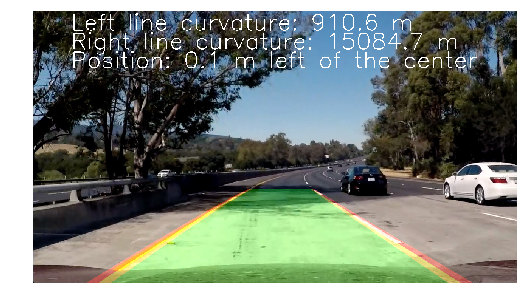

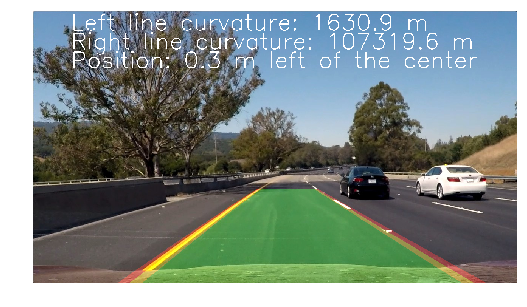

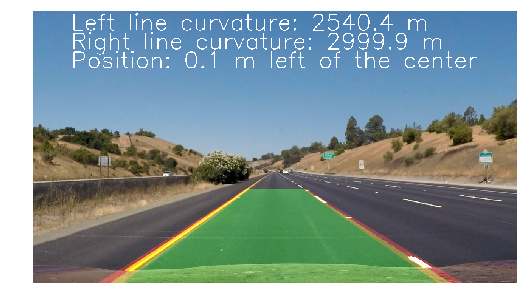

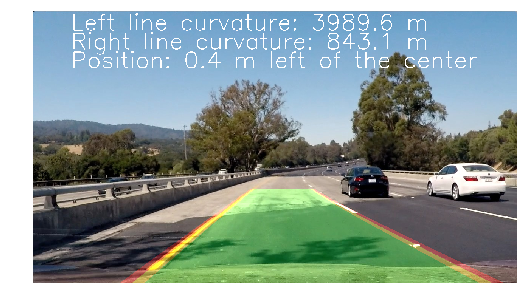

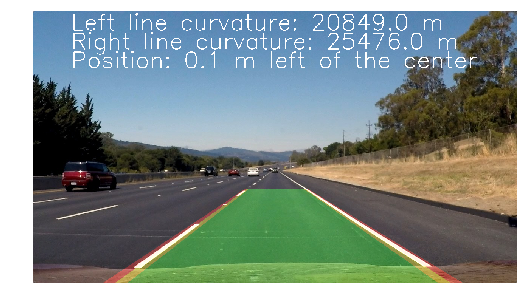

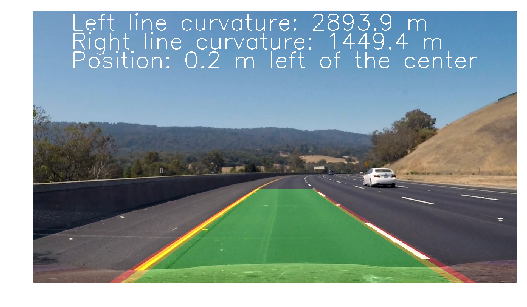

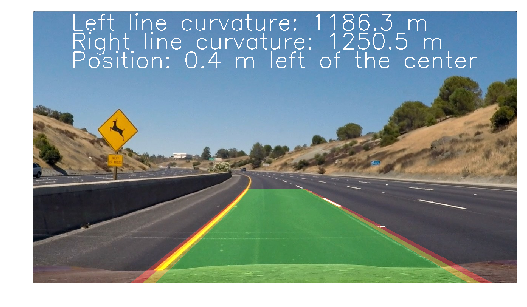

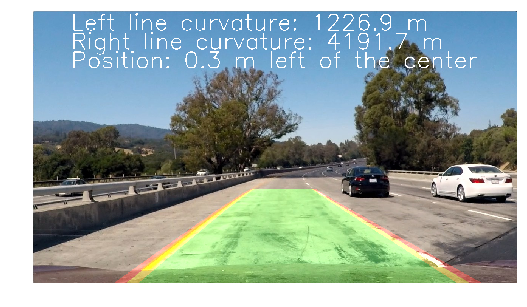

In [42]:
test_images = glob.glob('data/test_images/*.jpg')

for img_path in test_images:

    img = mpimg.imread(img_path)
    # Create a new LaneFindingPipeline
    pipeline = Pipeline(remover=Remover)
    
    # Run it on the image
    img_out = pipeline.run(img)
    
    # Display
    plt.figure();
    plt.imshow(img_out); 
    plt.axis('off');
    plt.savefig("data/report_images/" + img_path.split("/")[-1])


## Video

In [43]:
pipeline = Pipeline()
video = "data/videos/project_video.mp4"
clip = VideoFileClip(video)
clip_processed = clip.fl_image(pipeline.run)

_, video_name = os.path.split(video)
out_name = os.path.join("data/report_images/", video_name)
clip_processed.write_videofile(out_name, audio=False)

Calibrating camera...
Not possible to extract points from image: data/camera_cal/calibration1.jpg.
Not possible to extract points from image: data/camera_cal/calibration5.jpg.
Not possible to extract points from image: data/camera_cal/calibration4.jpg.
Calibration completed...
[MoviePy] >>>> Building video data/report_images/project_video.mp4
[MoviePy] Writing video data/report_images/project_video.mp4


100%|█████████▉| 1260/1261 [02:29<00:00,  9.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/report_images/project_video.mp4 

